In [686]:
%pylab inline
indir = '/mnt/store1/oliverphilcox/3PCF_SE/3PCFCovMatricesAll/'
n=15
l=8
m=l+1

Populating the interactive namespace from numpy and matplotlib


#### Load first integral part

In [687]:
def symmetrize(mat):
    """ Add in symmetries to matrices """
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)//m):
        a = i//n
        b = i%n
        for j in range(len(mat)//m):
            c = j//n
            d = j%n
            # Add to all relevant bins
            these_mat = mat[i*m:(i+1)*m,j*m:(j+1)*m]*0.25
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(c*n+d)*m:(c*n+d)*m+m]+=these_mat
            out_mat[(b*n+a)*m:(b*n+a)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
            out_mat[(a*n+b)*m:(a*n+b)*m+m,(d*n+c)*m:(d*n+c)*m+m]+=these_mat
    return 0.5*(out_mat+out_mat.T)

In [666]:
def plotter(mat):
    vmax=np.percentile(mat,99.)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
    plt.colorbar();
    plt.ylim([-0.5,len(mat)-0.5])
    plt.xlim([-0.5,len(mat)-0.5])

In [667]:
def rebinner(mat):
    out_mat = np.zeros_like(mat)
    for i in range(m):
        for j in range(m):
            out_mat[i*n*n:(i+1)*n*n,j*n*n:(j+1)*n*n]=mat[i::m,j::m]
    return out_mat

In [668]:
total_counts = np.loadtxt('/mnt/store1/oliverphilcox/3PCF_SE/3PCFCovMatricesAll/total_counts_n%d_m%d_0.txt'%(n,m))

In [669]:
print("Triples: %.1e Quads: %.1e, Quints: %.1e, Hexes: %.1e"%(total_counts[0],total_counts[1],total_counts[2],total_counts[3]))

Triples: 5.1e+08 Quads: 1.0e+09, Quints: 2.1e+09, Hexes: 4.1e+09


In [670]:
bins_r = np.loadtxt('/mnt/store1/oliverphilcox/3PCF/SE_binning_n15.csv')

In [671]:
print('Radial Bins')
print(bins_r[:,0])
print(bins_r[:,1])
delta_r = bins_r[-1,0]-bins_r[-2,0]

Radial Bins
[ 30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160.
 170.]
[ 40.  50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170.
 180.]


In [672]:
c30=np.loadtxt(indir+'c3_n%d_l%d_0_full.txt'%(n,l))
c40=np.loadtxt(indir+'c4_n%d_l%d_0_full.txt'%(n,l))
c50=np.loadtxt(indir+'c5_n%d_l%d_0_full.txt'%(n,l))
c60=np.loadtxt(indir+'c6_n%d_l%d_0_full.txt'%(n,l))
c31=np.loadtxt(indir+'c3_n%d_l%d_1_full.txt'%(n,l))
c41=np.loadtxt(indir+'c4_n%d_l%d_1_full.txt'%(n,l))
c51=np.loadtxt(indir+'c5_n%d_l%d_1_full.txt'%(n,l))
c61=np.loadtxt(indir+'c6_n%d_l%d_1_full.txt'%(n,l))
c3=c30+c31
c4=c40+c41
c5=c50+c51
c6=c60+c61

In [673]:
c3s=symmetrize(c3)
c4s=symmetrize(c4)
c5s=symmetrize(c5)
c6s=symmetrize(c6)

## Use SE compression

In [674]:
good_r_bins=[]
for b1 in range(n):
    for b2 in range(n):
        r1=bins_r[b1,0]
        r2=bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            good_r_bins.append(b1)
good_r_bins = np.unique(np.asarray(good_r_bins))
n_g = len(good_r_bins)
min_r_bin = min(good_r_bins)

In [675]:
def compression(mat):
    comp_mat = np.zeros([n_g*m,n_g*m])
    den = np.zeros([n_g*m,n_g*m])

    all_v = 4.*np.pi*(bins_r[:,1]**3-bins_r[:,0]**3)/3

    for i in range(len(mat)):
        l = i%m
        b1 = (i//m)//n
        r1 = bins_r[b1,0]
        if b1<min_r_bin:
            continue
        b2 = (i//m)%n
        r2 = bins_r[b2,0]
        if (r2>=3*delta_r) and (r2<r1-3*delta_r):
            v_b2 = all_v[b2]

            for j in range(len(mat)):
                l2 = j%m
                b3 = (j//m)//n
                r3 = bins_r[b3,0]
                if b3<min_r_bin:
                    continue
                b4 = (j//m)%n
                r4 = bins_r[b4,0]
                if (r4>=3*delta_r) and (r4<r3-3*delta_r):
                    v_b4 = all_v[b4]

                    comp_mat[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=mat[i,j]*v_b2*v_b4
                    den[l*n_g+b1-min_r_bin,l2*n_g+b3-min_r_bin]+=v_b2*v_b4

    comp_mat/=den
    return comp_mat

In [676]:
c3se=compression(c3s)
c4se=compression(c4s)
c5se=compression(c5s)
c6se=compression(c6s)

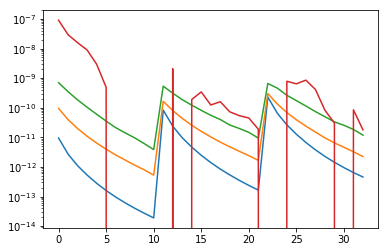

In [677]:
plt.plot(np.diag(c3se))
plt.plot(np.diag(c4se))
plt.plot(np.diag(c5se))
plt.plot(np.diag(c6se))
plt.yscale('log')

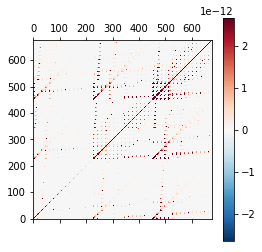

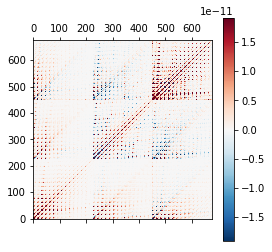

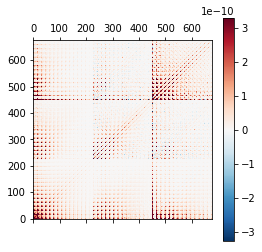

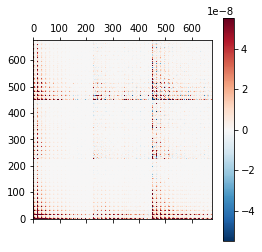

In [678]:
plotter(rebinner(c3s))
plotter(rebinner(c4s))
plotter(rebinner(c5s))
plotter(rebinner(c6s))

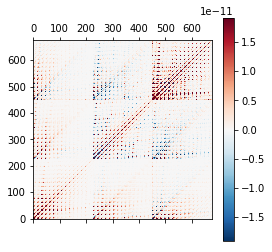

In [679]:
plotter(rebinner(c4s))

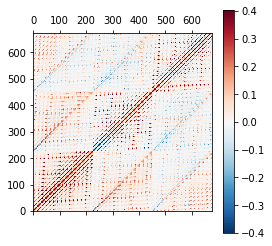

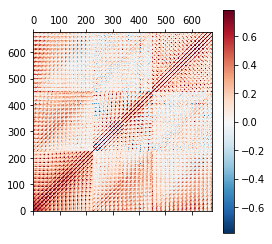

In [680]:
plotter(reduce(rebinner(c4s)))
plotter(reduce(rebinner(c5s)))

In [681]:
def reduce(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

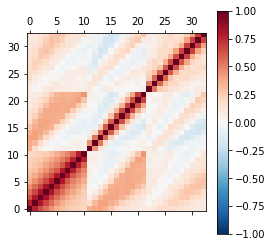

In [685]:
plotter(reduce(c5se+c4se+c3se))

**Difference between two C3 estimates**~

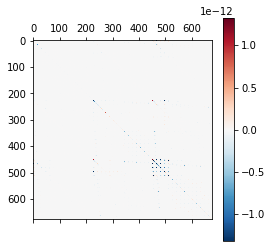

In [636]:
mat=rebinner(symmetrize(c30-c31))
vmax=np.percentile(rebinner(symmetrize(c30)),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
plt.colorbar();

In [637]:
tot_mat = symmetrize(c3+c4+c5+c6)

## Total Matrix

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


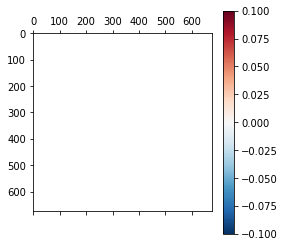

<Figure size 432x288 with 0 Axes>

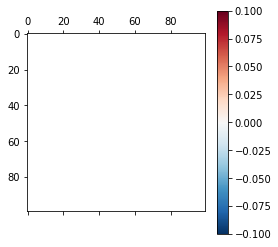

In [638]:
plotter(rebinner(symmetrize(tot_mat)))
plt.figure()
plotter(rebinner(symmetrize(tot_mat))[:100,:100])

In [639]:
b30=np.loadtxt(indir+'binct_c3_n%d_l%d_0_full.txt'%(n,l))
b40=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b50=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b60=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b31=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b41=np.loadtxt(indir+'binct_c4_n%d_l%d_0_full.txt'%(n,l))
b51=np.loadtxt(indir+'binct_c5_n%d_l%d_0_full.txt'%(n,l))
b61=np.loadtxt(indir+'binct_c6_n%d_l%d_0_full.txt'%(n,l))

**6-point Sampling**

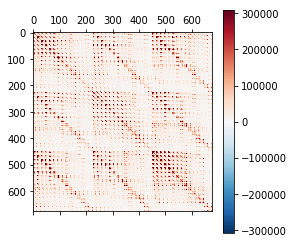

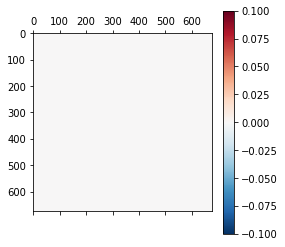

In [640]:
plotter(rebinner(symmetrize(b60)))
plotter(rebinner(symmetrize(b61)))

**3 Point**

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


(0, 300)

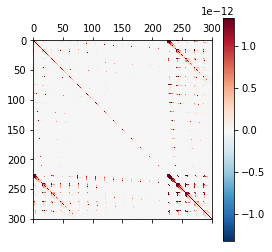

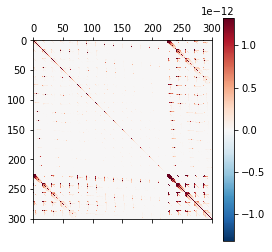

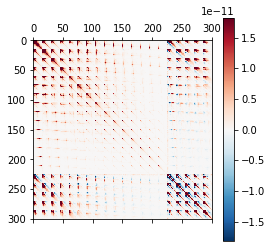

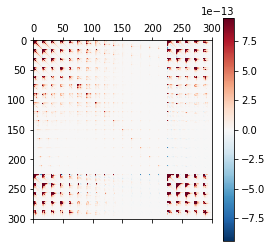

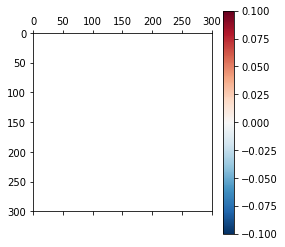

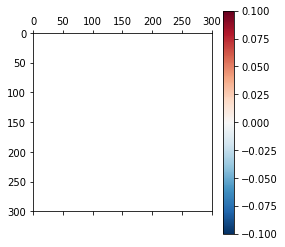

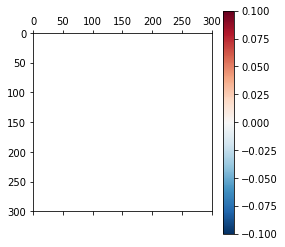

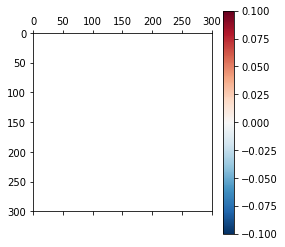

In [642]:
plotter(rebinner(symmetrize(c31)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c30)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c41)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c40)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c51)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c50)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c61)));plt.ylim([300,0]);plt.xlim([0,300])
plotter(rebinner(symmetrize(c60)));plt.ylim([300,0]);plt.xlim([0,300])

In [643]:
def collapse_axes(mat,c_bin,d_bin):
    new_mat = np.zeros([m,m,n,n])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin,q_bin,a_bin,b_bin] = mat[i,c_bin*n+d_bin*m+q_bin]
    return new_mat

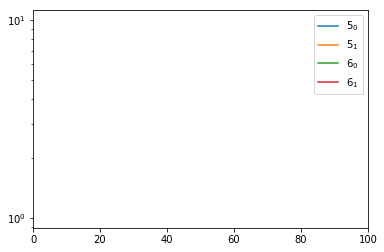

In [644]:
plt.plot(np.diag(rebinner(symmetrize(c50)))[:n*n],label=r'$5_0$')
plt.plot(np.diag(rebinner(symmetrize(c51)))[:n*n],label=r'$5_1$')
plt.plot(np.diag(rebinner(symmetrize(c60)))[:n*n],label=r'$6_0$')
plt.plot(np.diag(rebinner(symmetrize(c61)))[:n*n],label=r'$6_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

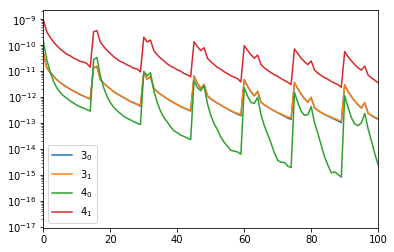

In [645]:
plt.plot(np.diag(rebinner(symmetrize(c30)))[:n*n],label=r'$3_0$')
plt.plot(np.diag(rebinner(symmetrize(c31)))[:n*n],label=r'$3_1$')
plt.plot(np.diag(rebinner(symmetrize(c40)))[:n*n],label=r'$4_0$')
plt.plot(np.diag(rebinner(symmetrize(c41)))[:n*n],label=r'$4_1$')
plt.legend();plt.xlim([0,100])
plt.yscale('log');

In [646]:
def variance(mat):
    out_mat = np.zeros([m,n,n])
    for p in range(m):
        for i in range(n):
            for j in range(n):
                out_mat[p,i,j]=mat[(i*n+j)*m+p,(i*n+j)*m+p]
    return out_mat

In [647]:
collapsed_mat = collapse_axes(tot_mat,5,7)
collapsed_mat.shape

(3, 3, 15, 15)

In [648]:
def collapse_axes_all_corr(mat,c_bin,d_bin):
    new_mat = np.zeros([n*m,n*m])
    for i in range(len(mat)):
        p_bin = i%m
        a_bin = (i//m)//n
        b_bin = (i//m)%n
        for q_bin in range(m):
            new_mat[p_bin*n+a_bin,q_bin*n+b_bin] += mat[i,c_bin*n*m+d_bin*m+q_bin]
    # Now compute correlation matrix
    corr_mat = np.zeros([n*m,n*m])
    for i in range(len(corr_mat)):
        p_bin = i//n
        a_bin = i%n
        for j in range(len(corr_mat[0])):
            q_bin = j//n
            b_bin = j%n
            corr_mat[p_bin*n+a_bin,q_bin*n+b_bin]=new_mat[p_bin*n+a_bin,q_bin*n+b_bin]/np.sqrt(new_mat[p_bin*n+a_bin,q_bin*n+a_bin]*new_mat[p_bin*n+b_bin,q_bin*n+b_bin])
    return corr_mat

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


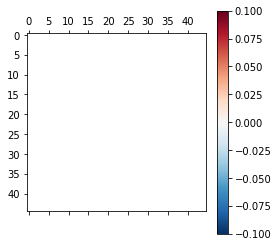

In [649]:
collapsed_mat = collapse_axes_all_corr(tot_mat,5,7)
vmax=np.percentile(collapsed_mat,99.9)
plt.matshow(collapsed_mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
#plt.title(r'$C_{%d%d}$'%(2*i,2*j))
plt.colorbar();

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


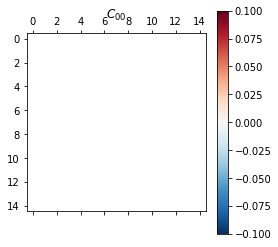

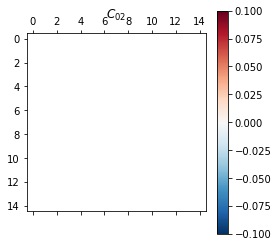

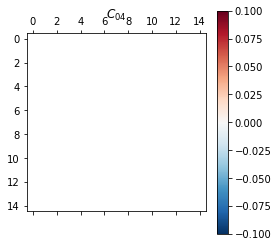

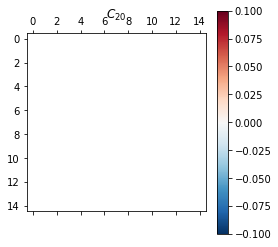

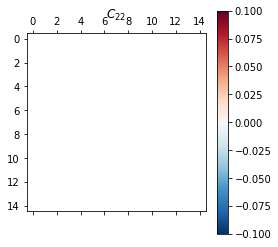

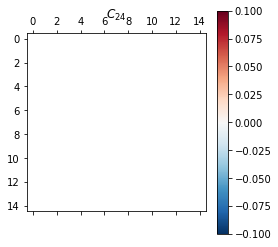

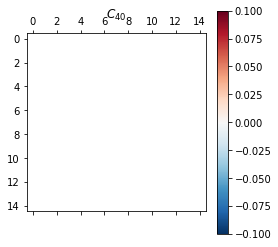

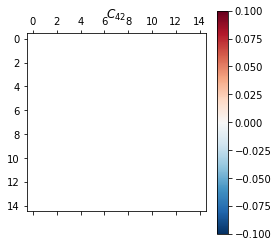

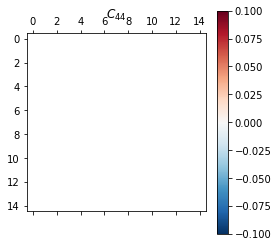

In [650]:
collapsed_mat = collapse_axes(tot_mat,5,2)
for i in range(3):
    for j in range(3):
        vmax=np.percentile(collapsed_mat[i,j],99.9)
        plt.matshow(collapsed_mat[i,j],vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);
        plt.title(r'$C_{%d%d}$'%(2*i,2*j))
        plt.colorbar();